In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats

In [2]:
#np.random.seed(2021)

In [3]:
def gaussmf(x, mean, sigma):

    return np.exp(-((x - mean)**2.) / (2 * sigma**2.))

In [4]:
df = pd.read_csv('transfusion.csv')

In [5]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [6]:
df.head(10)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
5,4,4,1000,4,0
6,2,7,1750,14,1
7,1,12,3000,35,0
8,2,9,2250,22,1
10,4,23,5750,58,0
11,0,3,750,4,0
12,2,10,2500,28,1


In [7]:
df_x = df.drop(['whether he/she donated blood in March 2007'], axis=1)

In [8]:
dict = {}
for k in df_x.keys():
    mean = df_x.mean()[k]
    sigma = df_x.std()[k]
    x = df_x[k]
    small = gaussmf(x, mean - sigma, sigma)
    medium = gaussmf(x, mean, sigma)
    large = gaussmf(x, mean + sigma, sigma)

    dict[k+'_s'] = small
    dict[k+'_m'] = medium
    dict[k+'_l'] = large

In [9]:
X = pd.DataFrame(dict)

In [10]:
X.head(10)

,Recency (months)_s,Recency (months)_m,Recency (months)_l,Frequency (times)_s,Frequency (times)_m,Frequency (times)_l,Monetary (c.c. blood)_s,Monetary (c.c. blood)_m,Monetary (c.c. blood)_l,Time (months)_s,Time (months)_m,Time (months)_l
1,0.953353,0.424490,0.069532,0.017067,0.179545,0.694860,0.017067,0.179545,0.694860,0.739111,0.975566,0.473706
2,0.986152,0.506139,0.095566,0.001811,0.038377,0.299167,0.001811,0.038377,0.299167,0.561255,0.997208,0.651804
3,0.999690,0.591431,0.128721,0.000042,0.002287,0.045358,0.000042,0.002287,0.045358,0.324956,0.882772,0.882222
5,0.966942,0.760088,0.219803,0.753429,0.969834,0.459259,0.753429,0.969834,0.459259,0.971271,0.462734,0.081101
6,0.999690,0.591431,0.128721,0.348106,0.902584,0.860933,0.348106,0.902584,0.860933,0.983370,0.716318,0.191956
7,0.986152,0.506139,0.095566,0.032328,0.269288,0.825213,0.032328,0.269288,0.825213,0.561255,0.997208,0.651804
8,0.999690,0.591431,0.128721,0.158433,0.655190,0.996773,0.158433,0.655190,0.996773,0.872261,0.892389,0.335867
10,0.966942,0.760088,0.219803,0.000001,0.000156,0.006220,0.000001,0.000156,0.006220,0.121966,0.575414,0.998683
11,0.953353,0.424490,0.069532,0.873964,0.890789,0.334012,0.873964,0.890789,0.334012,0.971271,0.462734,0.081101
12,0.999690,0.591431,0.128721,0.098496,0.514415,0.988361,0.098496,0.514415,0.988361,0.739111,0.975566,0.473706


In [11]:
y = pd.get_dummies(df['whether he/she donated blood in March 2007'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
#T function
def T(x,L1,L2,cn):
    r = x - np.dot(L1,x) + L2
    s = np.abs(r)-cn
    s = np.maximum(s,0,s)
    return s*np.sign(r)

def thetan(x0,x1,n):
    if (x0==x1).all():
        return 0
    else:
        return 1/(2**n*np.linalg.norm(x1-x0,'fro'))

In [14]:
H = X_train
itrs = 500
L = 1. / np.max(np.linalg.eigvals(np.dot(H.T, H))).real
m = H.shape[1]
n = y_train.shape[1]
x0 = np.zeros((m,n))
x1 = np.zeros((m,n))
L1 = 2*L*np.dot(H.T, H)
L2 = 2*L*np.dot(H.T, y_train)
lam = 1e-2
acc_rate_validation = []
acc_rate_train = []
for i in range(1,itrs+1):
    cn = ((2e-6*i)/(2*i+1))*lam*L
    beta = 0.9*i/(i+1)
    alpha = 0.9*i/(i+1)

    y = x1 + thetan(x0,x1,i)*(x1-x0)
    z = (1-beta)*x1 + beta*T(x1,L1,L2,cn)

    Ty = T(y,L1,L2,cn)
    Tz = T(z,L1,L2,cn)
    x = (1-alpha)*Ty + alpha*Tz

    x0, x1 = x1, x
    
    W = x

    predict_val = X_test.dot(W).values

    actual_val  = y_test.values

    acc_rate_validation.append([i, np.sum(np.argmax(predict_val, axis=1) == np.argmax(actual_val, axis=1)) / y_test.shape[0]])
    
    predict_train = X_train.dot(W).values

    actual_train  = y_train.values

    acc_rate_train.append([i, np.sum(np.argmax(predict_train, axis=1) == np.argmax(actual_train, axis=1)) / y_train.shape[0]])

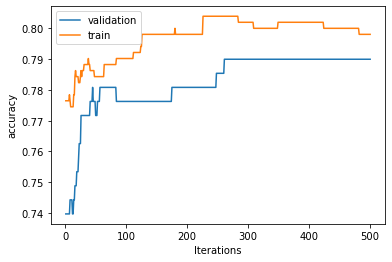

In [18]:
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.plot(range(1,itrs+1), [x[1] for x in acc_rate_validation], label='validation')
plt.plot(range(1,itrs+1), [x[1] for x in acc_rate_train], label='train')
plt.legend()
plt.savefig('acc.png')